In [1]:
import newspaper
import pandas as pd
from tqdm import auto
import ray
from newspaper import Article, Config
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
USER_AGENT = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:78.0) Gecko/20100101 Firefox/78.0'
config = Config()
config.browser_user_agent = USER_AGENT
ray.init()

{'node_ip_address': '127.0.0.1',
 'raylet_ip_address': '127.0.0.1',
 'redis_address': '127.0.0.1:6379',
 'object_store_address': '/tmp/ray/session_2021-11-28_18-00-54_491231_11871/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-11-28_18-00-54_491231_11871/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2021-11-28_18-00-54_491231_11871',
 'metrics_export_port': 64691,
 'node_id': '4352f5dc2f5fb639d85bb16595ffedbea1b16f0c37acf0d35765421f'}

In [2]:
@ray.remote
def get_article(url):
    try:
        article = Article(url, config=config)
        article.download()
        article.parse()
        article.text
        article.title
        return [article.title, article.text]
    except:
        return []


In [3]:
def parmap(f, list):
    return [f.remote(x) for x in list]

In [4]:
df = pd.read_csv('http://data.gdeltproject.org/gdeltv2/masterfilelist.txt',sep=" ", names=['id', 'hash', 'file'])

In [5]:
df['split'] = df.file.str.split('/')

In [6]:
df.split.sample(2)

534354    [http:, , data.gdeltproject.org, gdeltv2, 2020...
484460    [http:, , data.gdeltproject.org, gdeltv2, 2019...
Name: split, dtype: object

In [7]:
valid = df[df.split.apply(lambda x: type(x)) == type([])]

In [8]:
valid.loc[:,'sub_split'] = valid.split.apply(lambda x: x[-1].split('.'))

/Users/hhoferic/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [9]:
valid.loc[:,'ts'] = valid.sub_split.apply(lambda x: x[0])
valid.loc[:,'type'] = valid.sub_split.apply(lambda x: x[1])

In [10]:
ts_valid = valid.sort_values('ts', ascending=False).set_index('ts')

In [11]:
extracts = []
shuffeled_index = ts_valid.sample(frac=1).index
for _id, index in enumerate(auto.tqdm(shuffeled_index)):
    ts_current = ts_valid.loc[index]

    ts_current_export = ts_current[ts_current.type == 'export']
    ts_current_mentions = ts_current[ts_current.type == 'mentions']

    try:
        df_export = pd.read_csv(
            ts_current_export.file.values[0], 
            compression='zip', 
            sep ='\t', 
            header=None, 
            usecols=[0,56,57,60], 
            names=['id', 'lat', 'lon', 'url']
        )

        df_mentions = pd.read_csv(
            ts_current_mentions.file.values[0], 
            compression='zip', sep ='\t', 
            header=None, 
            usecols=[0, 5, 11], 
            names=['id', 'url_2', 'conf']
        )
    except:
        continue

    df_join = df_export.set_index('id').join(df_mentions.set_index('id'))
    df_join = df_join[df_join['url'] == df_join['url_2']]
    df_join = df_join.drop(columns='url_2')
    df_join = df_join[df_join.conf >= 90]
    df_join = df_join.dropna(subset=['lat', 'lon'])
    df_join = df_join.drop_duplicates(subset=['lat', 'lon', 'url'])
    articles = ray.get(parmap(get_article, df_join.url.values))
    df_join.loc[:,'articles'] = articles 

    extracts.append(df_join)
    
    if _id%50 == 0:
        all_extracts = pd.concat(extracts)
        all_extracts.to_json('data/gdelt_extracts_new.json', orient='records', lines=True)



  0%|          | 0/696425 [00:00<?, ?it/s]

(pid=11889) /Users/hhoferic/anaconda3/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname IST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
(pid=11889)   warnings.warn("tzname {tzname} identified but not understood.  "


(get_article pid=11890) 


(pid=11887) /Users/hhoferic/anaconda3/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname IST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
(pid=11887)   warnings.warn("tzname {tzname} identified but not understood.  "
(pid=11888) /Users/hhoferic/anaconda3/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname IST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
(pid=11888)   warnings.warn("tzname {tzname} identified but not understood.  "
(pid=11884) /Users/hhoferic/anaconda3/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname PST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime. 

(get_article pid=11890) 


(pid=11893) /Users/hhoferic/anaconda3/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname IST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
(pid=11893)   warnings.warn("tzname {tzname} identified but not understood.  "
(pid=11893) Building prefix dict from /Users/hhoferic/anaconda3/lib/python3.8/site-packages/jieba/dict.txt ...
(pid=11893) Loading model from cache /var/folders/4b/w4q7xvkd0fv6dt8qs7phqdjw0000gp/T/jieba.cache
(pid=11893) Loading model cost 0.9108669757843018 seconds.
(pid=11893) Prefix dict has been built succesfully.
(pid=11887) /Users/hhoferic/anaconda3/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
(pid=

(get_article pid=11886) 
(get_article pid=11887) 


(pid=11895) /Users/hhoferic/anaconda3/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname PST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
(pid=11895)   warnings.warn("tzname {tzname} identified but not understood.  "


(get_article pid=11885) 


(pid=11887) /Users/hhoferic/anaconda3/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
(pid=11887)   warnings.warn("tzname {tzname} identified but not understood.  "


(get_article pid=11894) 


(pid=11885) Building prefix dict from /Users/hhoferic/anaconda3/lib/python3.8/site-packages/jieba/dict.txt ...
(pid=11885) Loading model from cache /var/folders/4b/w4q7xvkd0fv6dt8qs7phqdjw0000gp/T/jieba.cache
(pid=11885) Loading model cost 0.8789851665496826 seconds.
(pid=11885) Prefix dict has been built succesfully.
(pid=11886) Building prefix dict from /Users/hhoferic/anaconda3/lib/python3.8/site-packages/jieba/dict.txt ...
(pid=11886) Loading model from cache /var/folders/4b/w4q7xvkd0fv6dt8qs7phqdjw0000gp/T/jieba.cache
(pid=11886) Loading model cost 0.8788888454437256 seconds.
(pid=11886) Prefix dict has been built succesfully.
(pid=11888) Building prefix dict from /Users/hhoferic/anaconda3/lib/python3.8/site-packages/jieba/dict.txt ...
(pid=11888) Loading model from cache /var/folders/4b/w4q7xvkd0fv6dt8qs7phqdjw0000gp/T/jieba.cache
(pid=11888) Loading model cost 0.8604209423065186 seconds.
(pid=11888) Prefix dict has been built succesfully.


(get_article pid=11893) 
(get_article pid=11888) 
(get_article pid=11892) 


(pid=11889) /Users/hhoferic/anaconda3/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname IST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
(pid=11889)   warnings.warn("tzname {tzname} identified but not understood.  "
(pid=11890) Building prefix dict from /Users/hhoferic/anaconda3/lib/python3.8/site-packages/jieba/dict.txt ...
(pid=11890) Loading model from cache /var/folders/4b/w4q7xvkd0fv6dt8qs7phqdjw0000gp/T/jieba.cache
(pid=11890) Loading model cost 0.846743106842041 seconds.
(pid=11890) Prefix dict has been built succesfully.


(get_article pid=11894) 
(get_article pid=11893) 


(pid=11894) /Users/hhoferic/anaconda3/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
(pid=11894)   warnings.warn("tzname {tzname} identified but not understood.  "
(pid=11887) Building prefix dict from /Users/hhoferic/anaconda3/lib/python3.8/site-packages/jieba/dict.txt ...
(pid=11887) Loading model from cache /var/folders/4b/w4q7xvkd0fv6dt8qs7phqdjw0000gp/T/jieba.cache
(pid=11887) Loading model cost 0.8799929618835449 seconds.
(pid=11887) Prefix dict has been built succesfully.
(pid=11892) /Users/hhoferic/anaconda3/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname IST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
(pid=

(get_article pid=11887) 


(pid=11885) /Users/hhoferic/anaconda3/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname IST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
(pid=11885)   warnings.warn("tzname {tzname} identified but not understood.  "


(get_article pid=11891) 


(pid=11887) /Users/hhoferic/anaconda3/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname IST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
(pid=11887)   warnings.warn("tzname {tzname} identified but not understood.  "
(pid=11891) /Users/hhoferic/anaconda3/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
(pid=11891)   warnings.warn("tzname {tzname} identified but not understood.  "
(pid=11891) Building prefix dict from /Users/hhoferic/anaconda3/lib/python3.8/site-packages/jieba/dict.txt ...
(pid=11891) Loading model from cache /var/folders/4b/w4q7xvkd0fv6dt8qs7phqdjw0000gp/T/jieba.cache
(pid=11891) Loading model cost 0.8433

(get_article pid=11889) 


(pid=11885) /Users/hhoferic/anaconda3/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
(pid=11885)   warnings.warn("tzname {tzname} identified but not understood.  "


(get_article pid=11895) 


(pid=11893) /Users/hhoferic/anaconda3/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname IST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
(pid=11893)   warnings.warn("tzname {tzname} identified but not understood.  "
(pid=11890) /Users/hhoferic/anaconda3/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname IST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
(pid=11890)   warnings.warn("tzname {tzname} identified but not understood.  "
(pid=11884) /Users/hhoferic/anaconda3/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname PST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime. 

(get_article pid=11891) 
(get_article pid=11890) 


(pid=11892) /Users/hhoferic/anaconda3/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname PST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
(pid=11892)   warnings.warn("tzname {tzname} identified but not understood.  "
(pid=11889) /Users/hhoferic/anaconda3/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname PST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
(pid=11889)   warnings.warn("tzname {tzname} identified but not understood.  "
(pid=11884) /Users/hhoferic/anaconda3/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime. 

(get_article pid=11894) 


(pid=11893) /Users/hhoferic/anaconda3/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
(pid=11893)   warnings.warn("tzname {tzname} identified but not understood.  "
(pid=11894) /Users/hhoferic/anaconda3/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
(pid=11894)   warnings.warn("tzname {tzname} identified but not understood.  "


(get_article pid=11895) 


(pid=11893) /Users/hhoferic/anaconda3/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname PST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
(pid=11893)   warnings.warn("tzname {tzname} identified but not understood.  "
(pid=11885) /Users/hhoferic/anaconda3/lib/python3.8/site-packages/PIL/Image.py:2966: UserWarning: image file could not be identified because WEBP support not installed
(pid=11885)   warnings.warn(message)


(get_article pid=11884) 


(pid=11887) /Users/hhoferic/anaconda3/lib/python3.8/site-packages/PIL/Image.py:2966: UserWarning: image file could not be identified because WEBP support not installed
(pid=11887)   warnings.warn(message)
(pid=11892) /Users/hhoferic/anaconda3/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
(pid=11892)   warnings.warn("tzname {tzname} identified but not understood.  "
(pid=11889) /Users/hhoferic/anaconda3/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
(pid=11889)   warnings.warn("tzname {tzname} identified but not understood.  "
(pid=11894) Building prefix dict from /Us

(get_article pid=11890) 


(pid=11888) /Users/hhoferic/anaconda3/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
(pid=11888)   warnings.warn("tzname {tzname} identified but not understood.  "


(get_article pid=11892) 
(get_article pid=11893) 
(get_article pid=11887) 
(get_article pid=11892) 
(get_article pid=11889) 
(get_article pid=11894) 
(get_article pid=11891) 


(pid=11889) /Users/hhoferic/anaconda3/lib/python3.8/site-packages/PIL/Image.py:2966: UserWarning: image file could not be identified because WEBP support not installed
(pid=11889)   warnings.warn(message)


(get_article pid=11885) 


(pid=11893) /Users/hhoferic/anaconda3/lib/python3.8/site-packages/PIL/Image.py:2966: UserWarning: image file could not be identified because WEBP support not installed
(pid=11893)   warnings.warn(message)


(get_article pid=11889) 
(scheduler +11h56m47s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(scheduler +11h56m47s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(pid=11886) /Users/hhoferic/anaconda3/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
(pid=11886)   warnings.warn("tzname {tzname} identified but not understood.  "
(pid=11887) /Users/hhoferic/anaconda3/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
(pid=11887)   warnings.warn("tzname {tzname} identified but not understood.  "
(pid=11885) /Users/hhoferic/anaconda3/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime. 

(get_article pid=11893) 
(get_article pid=11890) 
(get_article pid=11884) 
(get_article pid=11886) 
(get_article pid=11890) 


(pid=11887) /Users/hhoferic/anaconda3/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
(pid=11887)   warnings.warn("tzname {tzname} identified but not understood.  "


(get_article pid=11889) 


(pid=11892) /Users/hhoferic/anaconda3/lib/python3.8/site-packages/PIL/Image.py:2966: UserWarning: image file could not be identified because WEBP support not installed
(pid=11892)   warnings.warn(message)


(get_article pid=11890) 
(get_article pid=11886) 
(get_article pid=11890) 
(get_article pid=11885) 
(get_article pid=11889) 
(get_article pid=11891) 
(get_article pid=11892) 
(get_article pid=11886) 
(get_article pid=11894) 
(get_article pid=11891) 
(get_article pid=11894) 
(get_article pid=11885) 
(get_article pid=11890) 


(pid=11884) /Users/hhoferic/anaconda3/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
(pid=11884)   warnings.warn("tzname {tzname} identified but not understood.  "


(get_article pid=11887) 
(get_article pid=11891) 
(get_article pid=11894) 
(get_article pid=11885) 


(pid=11893) /Users/hhoferic/anaconda3/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
(pid=11893)   warnings.warn("tzname {tzname} identified but not understood.  "


(get_article pid=11889) 
(get_article pid=11890) 
(get_article pid=11886) 
(get_article pid=11886) 
(get_article pid=11891) 
(get_article pid=11892) 


(pid=11886) /Users/hhoferic/anaconda3/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
(pid=11886)   warnings.warn("tzname {tzname} identified but not understood.  "


(get_article pid=11893) 


(pid=11895) /Users/hhoferic/anaconda3/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
(pid=11895)   warnings.warn("tzname {tzname} identified but not understood.  "
(pid=11894) /Users/hhoferic/anaconda3/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname CDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
(pid=11894)   warnings.warn("tzname {tzname} identified but not understood.  "


(get_article pid=11895) 
(get_article pid=11890) 
(get_article pid=11892) 


(pid=11888) /Users/hhoferic/anaconda3/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname CST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
(pid=11888)   warnings.warn("tzname {tzname} identified but not understood.  "


(get_article pid=11893) 
(get_article pid=11885) 
(get_article pid=11892) 
(get_article pid=11891) 
(get_article pid=11892) 
(get_article pid=11885) 


(pid=11888) /Users/hhoferic/anaconda3/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
(pid=11888)   warnings.warn("tzname {tzname} identified but not understood.  "


(get_article pid=11894) 


KeyboardInterrupt: 

In [55]:
all_extracts = pd.concat(extracts)

In [56]:
all_extracts.loc[:, 'lat'] = pd.to_numeric(all_extracts.lat)
all_extracts.loc[:, 'lon'] = pd.to_numeric(all_extracts.lon)

In [69]:
@ray.remote
def concat_text(_list):
     return " ".join(_list)

In [72]:
text = ray.get(parmap(concat_text, all_extracts.articles))

(concat_text pid=4525) 
(concat_text pid=4528) 
(concat_text pid=4528) 
(concat_text pid=4528) 
(concat_text pid=4530) 
(concat_text pid=4533) 
(concat_text pid=4524) 
(concat_text pid=4530) 
(concat_text pid=4533) 
(concat_text pid=4535) 
(concat_text pid=4525) 
(concat_text pid=4530) 
(concat_text pid=4530) 
(concat_text pid=4535) 
(concat_text pid=4531) 
(concat_text pid=4536) 
(concat_text pid=4531) 
(concat_text pid=4534) 
(concat_text pid=4535) 
(concat_text pid=4526) 
(concat_text pid=4526) 
(concat_text pid=4527) 
(concat_text pid=4528) 
(concat_text pid=4527) 
(concat_text pid=4535) 
(concat_text pid=4525) 
(concat_text pid=4531) 
(concat_text pid=4527) 
(concat_text pid=4534) 
(concat_text pid=4536) 
(concat_text pid=4536) 
(concat_text pid=4524) 
(concat_text pid=4524) 
(concat_text pid=4527) 
(concat_text pid=4534) 
(concat_text pid=4531) 
(concat_text pid=4535) 
(concat_text pid=4524) 
(concat_text pid=4527) 
(concat_text pid=4524) 
(concat_text pid=4528) 
(concat_text pid

In [74]:
all_extracts.loc[:, 'text'] = text

In [57]:
# all_extracts = all_extracts.drop_duplicates(subset=['lat', 'lon'])
all_extracts.to_json('data/gdelt_extracts_new.json', orient='records', lines=True)

<AxesSubplot:xlabel='lon', ylabel='lat'>

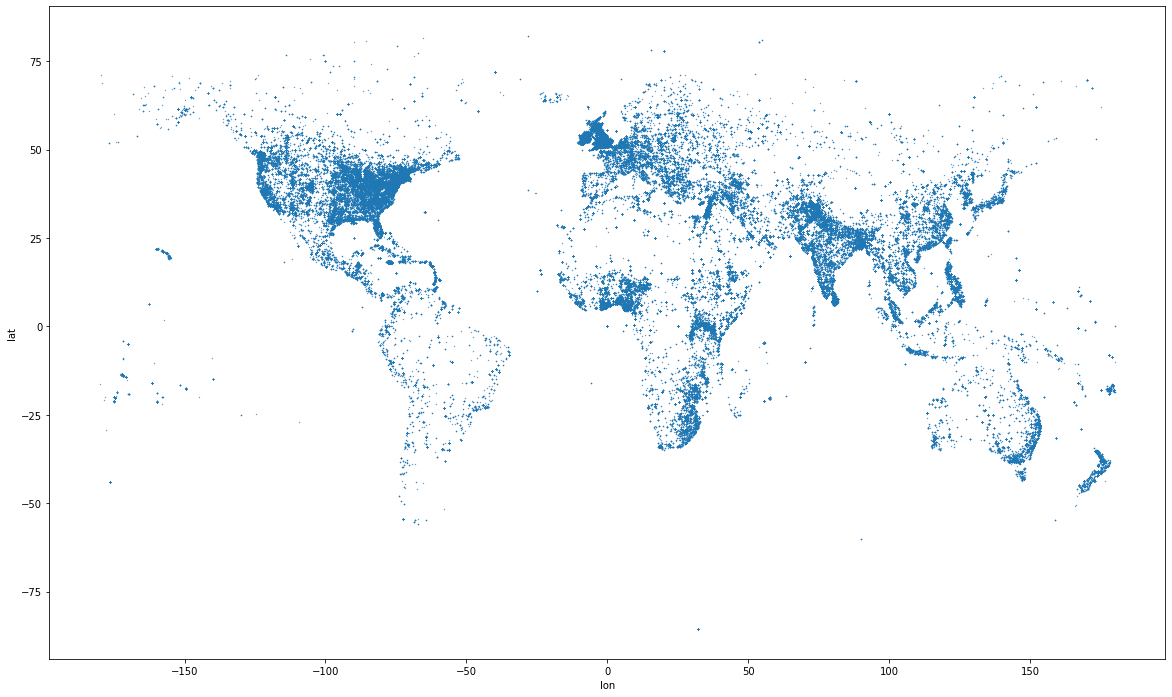

In [58]:
all_extracts.plot.scatter(x='lon', y='lat', figsize = (20,12), s=0.1)